I'm not sure library provide directed graph for GAT.

In [1]:
import networkx as nx
import stellargraph as sg
import pandas as pd
import numpy as np
import warnings
import tensorflow as tf

from sklearn import preprocessing, model_selection

from tensorflow.keras import layers, Model, optimizers, losses, callbacks

warnings.filterwarnings('ignore')
np.random.seed(0)
tf.random.set_seed(0)

In [2]:
from stellargraph import datasets

dataset = datasets.Cora()
G, target = dataset.load(directed=True)

In [3]:
tr_target, val_target = model_selection.train_test_split(
    target, train_size=0.2, stratify=target
)

val_target, test_target = model_selection.train_test_split(
    val_target, train_size=0.5, stratify=val_target
)

In [4]:
lbe = preprocessing.LabelBinarizer()

tr_target = pd.DataFrame(lbe.fit_transform(tr_target.values), index=tr_target.index)
val_target = pd.DataFrame(lbe.fit_transform(val_target.values), index=val_target.index)
test_target = pd.DataFrame(lbe.fit_transform(test_target.values), index=test_target.index)
tot_target = pd.DataFrame(lbe.fit_transform(target.values), index=target.index)

In [5]:
from stellargraph.mapper import FullBatchNodeGenerator

generator = FullBatchNodeGenerator(G, method='gat') # graph, bat_cum, sample_sum


In [6]:
tr_flow = generator.flow(tr_target.index, tr_target) # shuffle for better training
val_flow = generator.flow(val_target.index, val_target)
test_flow = generator.flow(test_target.index, test_target)
tot_flow = generator.flow(target.index, target)


In [7]:
from stellargraph.layer import GAT

gat = GAT([32, 16], activations=['elu', 'elu'], generator=generator, bias=True, dropout=0.3)
nc_inp, nc_out = gat.build()

In [8]:
nc_layer = layers.Dense(8, activation='relu')(nc_out)
nc_layer = layers.Dense(tr_target.shape[1], activation='softmax')(nc_out)

In [9]:
nc_model = Model(nc_inp, nc_layer)
nc_model.compile(loss=losses.categorical_crossentropy,
                optimizer=optimizers.Adam(),
                metrics=['acc'])

es = callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='val_acc')

In [10]:
nc_hist = nc_model.fit(tr_flow, epochs=200,
                      validation_data=val_flow,
                      callbacks=[es],
                      verbose=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']


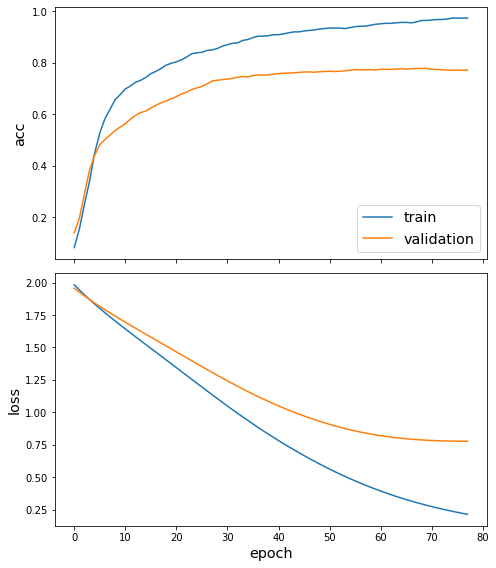

In [11]:
sg.utils.plot_history(nc_hist)

In [12]:
from sklearn.metrics import accuracy_score
lbe = preprocessing.LabelEncoder()

accuracy_score(list(map(np.argmax, test_target.values)), list(map(np.argmax, (nc_model.predict(test_flow).squeeze()))))


0.783210332103321

In [13]:
emb_model = Model(nc_inp, nc_out)

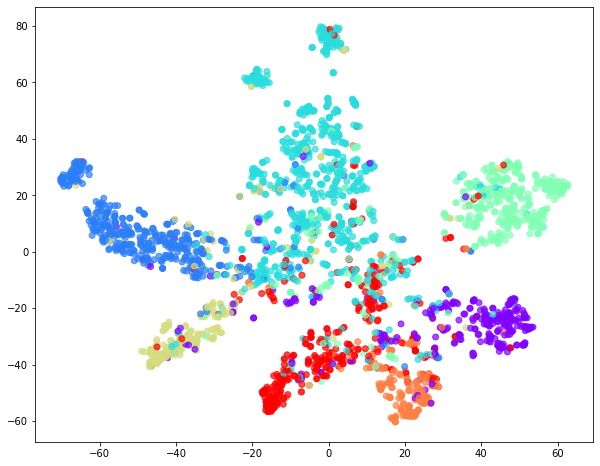

In [14]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2)
tsne_x = tsne.fit_transform(emb_model.predict(tot_flow).squeeze())

lbe = preprocessing.LabelEncoder()
col = lbe.fit_transform(target)

alpha = 0.7

plt.figure(figsize=(10, 8))
plt.scatter(
    tsne_x[:, 0],
    tsne_x[:, 1],
    cmap="rainbow",
    c=col,
    alpha=alpha,
)

In [15]:
directed_neigh_type = [
    1 * (len(G.in_nodes(node)) > 0) + 2 * (len(G.out_nodes(node)) > 0)
    for node in target.index
]

print(f"{sum(nt==0 for nt in directed_neigh_type)} nodes have no in or out neighbours")
print(f"{sum(nt==1 for nt in directed_neigh_type)} nodes have in but not out neighbours")
print(f"{sum(nt==2 for nt in directed_neigh_type)} nodes have out but no in neighbours")
print(f"{sum(nt==3 for nt in directed_neigh_type)} nodes have in and out neighbours")

0 nodes have no in or out neighbours
486 nodes have in but not out neighbours
1143 nodes have out but no in neighbours
1079 nodes have in and out neighbours


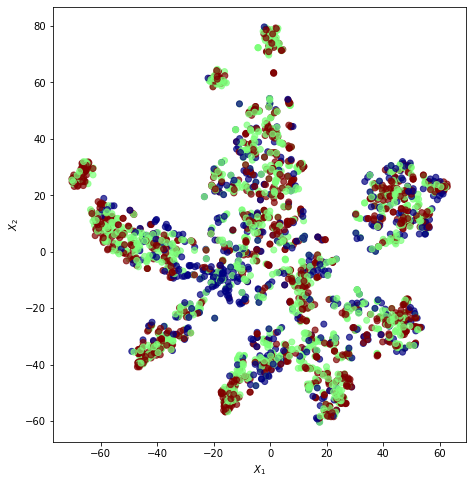

In [16]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(
    tsne_x[:, 0], tsne_x[:, 1], c=directed_neigh_type, cmap="jet", alpha=alpha
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")

plt.show()